# Unconformity or Onlap?
This notebook builds synthetic data to classify well logs based on stratal geometry. Specifically it is focused on classifying a well as either having an angular unconformity or onlapping a structural high. There is plenty of work that can be done going forward to build out the training data with more real world examples

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven',
         'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen'] #this creates dummy names for the formations
number_of_layers = 7 #this is the number of tops you want in your training data
neighbors = np.random.randint(1,200) #if we want to include neighbor data in training
df =  pd.DataFrame()

#this section builds some toy data with an angular unconformity
for j in np.arange(3,5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.rand(200)/100
    for i in range(len(names[0:number_of_layers])):
        layer_elevation = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.uniform(0,j)
        elevation = np.full(200, j)+np.random.rand(200)/100
        layer_elevation = np.where(layer_elevation > elevation, elevation, layer_elevation)+np.random.rand(200)/100
        rolling[names[i]] = layer_elevation
#this loop creates 0 values at random in the data much like you would see in an incomplete tops dataset
#the range value is the number of entries to set to zero
    for k in range(150):
        rolling.iloc[np.random.randint(0,199), np.random.randint(0,number_of_layers-1)] = 0
    df = pd.concat((df, rolling))
angular_thicknesses = df.T.diff(axis=0).abs().T #calculate formation thicknesses
#neigh = angular_thicknesses.shift(neighbors)
logged = angular_thicknesses.apply(np.log) #take the log of thicknesses for feature engineering
powered= angular_thicknesses.apply(lambda x: x**10) #calculates the power values of thickness for another feature
angular_thicknesses = pd.concat([angular_thicknesses, logged, powered], axis=1, join_axes=[angular_thicknesses.index]
                        ).drop(columns=['zero']).dropna().replace(-np.inf, 0) #dataframe of angular unconformity fm thicknesses

#now for onlap training data construction
df_onlap =  pd.DataFrame()
    
for j in np.arange(3,5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = 3*np.sin(np.arange(0,20,0.1)/6.28)
    for i in range(len(names[0:number_of_layers])):
        zero = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.rand(200)/100
        randomness = np.random.uniform(0,j)
        elevation = np.full(200, j)+np.random.rand(200)/100
        onlap = np.where(np.full(200,randomness) > zero, np.full(200,randomness)+np.random.rand(200)/100, zero)
        layer_elevation = np.where( onlap > elevation, elevation,  onlap)
        rolling[names[i]] = layer_elevation
#this loop creates 0 values at random in the data much like you would see in an incomplete tops dataset
#the range value is the number of entries to set to zero

    for k in range(150):
        rolling.iloc[np.random.randint(0,199), np.random.randint(0,number_of_layers-1)] = 0
    df_onlap = pd.concat((df_onlap, rolling))
onlap_thicknesses = df_onlap.T.diff(axis=0).abs().T
#neigh = onlap_thicknesses.shift(neighbors)
logged = onlap_thicknesses.apply(np.log)
powered= onlap_thicknesses.apply(lambda x: x**10)
onlap_thicknesses = pd.concat([onlap_thicknesses, logged, powered], axis=1, join_axes=[onlap_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#if you want to create a section with horizontal stratified training data this section will do it

df_horizontal =  pd.DataFrame()
    
for j in np.arange(3, 5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = np.full(200, 0)-np.random.rand(200)/100
    for i in range(len(names[0:number_of_layers])):
        randomness = np.random.uniform(0,j)
        elevation = np.full(200, j)+np.random.rand(200)/100
        horiz = np.full(200,randomness)
        layer_elevation = np.where( horiz > elevation, elevation,  horiz)
        rolling[names[i]] = layer_elevation
    for k in range(150):
        rolling.iloc[np.random.randint(0,199), np.random.randint(0,number_of_layers-1)] = 0
    df_horizontal = pd.concat((df_horizontal, rolling))
horizontal_thicknesses = df_horizontal.T.diff(axis=0).abs().T
#neigh = horizontal_thicknesses.shift(neighbors)
logged = horizontal_thicknesses.apply(np.log)
powered= horizontal_thicknesses.apply(lambda x: x**10)

horizontal_thicknesses = pd.concat([horizontal_thicknesses, logged, powered], axis=1, join_axes=[horizontal_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#normalize the data from 0 to 1
normalized_df=(angular_thicknesses-angular_thicknesses.min())/(angular_thicknesses.max()-angular_thicknesses.min()
                                                              ).replace(0,0.00001)
normalized_dfo=(onlap_thicknesses-onlap_thicknesses.min())/(onlap_thicknesses.max()-onlap_thicknesses.min()).replace(0,0.00001)
normalized_dfh=(horizontal_thicknesses-horizontal_thicknesses.min())/(horizontal_thicknesses.max()-horizontal_thicknesses.min()
                                                                     ).replace(0,0.00001)
#now assign classes to the datasets, 1 is onlap, 0 is angular unconformity
normalized_dfo['class'] = 1
normalized_df['class'] = 0
#normalized_dfh['class'] = 2

#merge into new dataset
dataset = pd.concat((normalized_df, normalized_dfo))


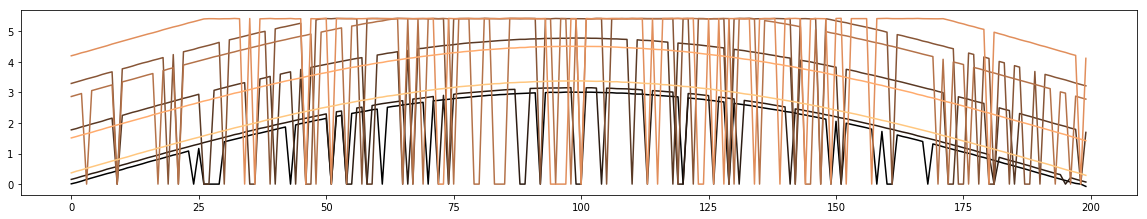

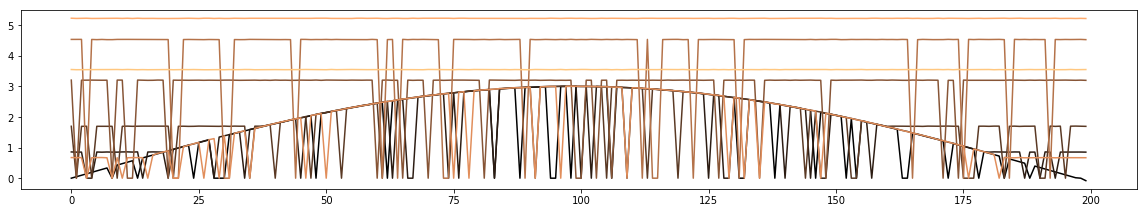

In [3]:
#now let's visualize what the stratigraphy looks like for our toy training data
df.iloc[-200:].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)
df_onlap.iloc[-200:].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)
#df_horizontal.iloc[1200:1400].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)

In [4]:
from sklearn.model_selection import train_test_split
#next let's split our toy data into training and test sets, choose how much with test_size of the data becomes the test set
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[0:, 0:-1].values, dataset.iloc[0:,-1].values, 
                                                    test_size=0.5, random_state=86)

In [5]:
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train) #this converts the target variable to one-hot encoding
y_test_encoded = to_categorical(y_test) #same with the test data conversion to one-hot encoding

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#Import keras and some layers, we are going to build a network with two dense layers and a dropout layer
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [28]:
#this is the network, we initialize with a dense layer and a relu activation
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5)) #dropout to avoid overfitting
model.add(Dense(2, kernel_initializer='random_uniform', activation='sigmoid')) #and another dense layer with sigmoid activation

In [62]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['binary_accuracy']) 
#builds the model, with categorical crossentropy for our loss function, optimizing using nadam, and using categorical accuracy
#as our accuracy metric

In [63]:
model.fit(X_train, y_train_encoded, epochs=60, batch_size=32) #Fitting the model for 60 epochs and batch size of 32

Epoch 1/60
5000/5000 [==============================] - 0s 88us/step - loss: 0.2771 - binary_accuracy: 0.8931
Epoch 2/60
5000/5000 [==============================] - 0s 34us/step - loss: 0.2722 - binary_accuracy: 0.8986
Epoch 3/60
5000/5000 [==============================] - 0s 37us/step - loss: 0.2736 - binary_accuracy: 0.8904
Epoch 4/60
5000/5000 [==============================] - 0s 37us/step - loss: 0.2781 - binary_accuracy: 0.8885
Epoch 5/60
5000/5000 [==============================] - 0s 35us/step - loss: 0.2797 - binary_accuracy: 0.8887
Epoch 6/60
5000/5000 [==============================] - 0s 34us/step - loss: 0.2750 - binary_accuracy: 0.8933
Epoch 7/60
5000/5000 [==============================] - 0s 34us/step - loss: 0.2717 - binary_accuracy: 0.8924
Epoch 8/60
5000/5000 [==============================] - 0s 36us/step - loss: 0.2694 - binary_accuracy: 0.8956
Epoch 9/60
5000/5000 [==============================] - 0s 35us/step - loss: 0.2699 - binary_accuracy: 0.8970
Epoch 10/6

In [64]:
score=model.evaluate(X_test, y_test_encoded) #tests the model on the test data
score

5000/5000 [==============================] - 0s 28us/step


[0.21604670708179474, 0.9303]

In [65]:
preds = model.predict(X_test) #creates predictions on the test data that we can use

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


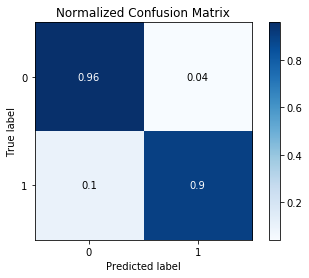

In [66]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, np.argmax(preds, axis=1), normalize=True) #let's visualize the predictions

In [67]:
#let's import some real world data from southwestern Wyoming
#this is from the Rock Springs Uplift in Wyoming and has been interpreted as an angular unconformity
tops = pd.read_csv(r'D:\real_data.csv').fillna(0) #this file is available in the unconformity or onlap folder in the repo
tops

,API,Latitude,Longitude,KB,GL,TD,Field,Formation_TD,Fox_Hills,Lewis,Almond,Ericson,Rock_Springs,Blair,Baxter,Frontier
0,3720898,41.64954,-108.79645,6670,6654,6617,Shiprock,Frontier,0,0,0.0,0.0,855.0,2050.0,3005.0,6285.0
1,3705616,41.62957,-108.67895,6681,6671,5135,0,Baxter,0,0,1205.0,1547.0,2565.0,4250.0,5010.0,0.0
2,3705564,41.60755,-108.51992,6747,6734,4710,Arch,Almond,3224,3498,4635.0,0.0,0.0,0.0,0.0,0.0
3,3723434,42.04156,-108.38434,6837,6821,10435,Hay Reservoir,Lewis,9105,9330,0.0,0.0,0.0,0.0,0.0,0.0
4,3720835,41.53297,-108.17385,7092,7078,12768,Wells Bluff,Rock Springs,8631,8770,10854.0,11292.0,11635.0,0.0,0.0,0.0
5,3721121,41.51786,-108.15494,7007,6992,11703,Wells Bluff,Rock Springs,8410,8709,10816.0,11230.0,11308.0,0.0,0.0,0.0
6,3721192,41.48193,-108.05939,6819,6804,11235,Wild Rose,Ericson,8358,8550,10677.0,11151.0,0.0,0.0,0.0,0.0
7,3721407,41.47498,-108.00095,6696,6680,10661,Wild Rose,Rock Springs,7563,7795,10033.0,10472.0,10647.0,0.0,0.0,0.0
8,721369,41.45313,-107.89628,6623,6607,9550,Wild Rose,0,6512,6795,9027.0,9538.0,0.0,0.0,0.0,0.0
9,720757,41.44524,-107.80960,6821,6806,9130,Baldy Butte,Rock Springs,5678,6030,8294.0,8725.0,8885.0,0.0,0.0,0.0


In [68]:
#clean up the real world data, take the tops from depth to thickness for each formation and get rid of negative thicknesses
tops2 = tops[tops.columns[8:]].T.diff().T.drop(columns=['Fox_Hills'])
tops2[tops2 < 0] =0
tops2

,Lewis,Almond,Ericson,Rock_Springs,Blair,Baxter,Frontier
0,0.0,0.0,0.0,855.0,1195.0,955.0,3280.0
1,0.0,1205.0,342.0,1018.0,1685.0,760.0,0.0
2,274.0,1137.0,0.0,0.0,0.0,0.0,0.0
3,225.0,0.0,0.0,0.0,0.0,0.0,0.0
4,139.0,2084.0,438.0,343.0,0.0,0.0,0.0
5,299.0,2107.0,414.0,78.0,0.0,0.0,0.0
6,192.0,2127.0,474.0,0.0,0.0,0.0,0.0
7,232.0,2238.0,439.0,175.0,0.0,0.0,0.0
8,283.0,2232.0,511.0,0.0,0.0,0.0,0.0
9,352.0,2264.0,431.0,160.0,0.0,0.0,0.0


In [69]:
#neigh = tops2.shift(1)
logged = tops2.apply(np.log) #creating the same features that we built in the training data
powered= tops2.apply(lambda x: x**10) #creating the same features that we built in the training data
tops3 = pd.concat([tops2, logged, powered], axis=1, join_axes=[tops2.index]
                               ).dropna().replace(-np.inf, 0)

In [70]:
normalized_tops3=(tops3-tops3.min())/(tops3.max()-tops3.min()).replace(0,0.00001) #normalize the data from 0 to 1
real_data = normalized_tops3.values

In [71]:
well_preds = model.predict(real_data) #make some predictions

In [72]:
predictions = np.argmax(well_preds, axis=1) #convert them to our binary classification

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

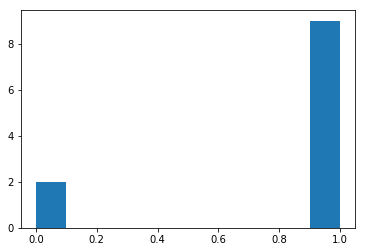

In [73]:
plt.hist(predictions) #visualize the predictions as a histogram, we are expecting all the wells to be classified as '0'

In [74]:
print('Accuracy on the real world data is '+str(100*(len(predictions)-np.sum(predictions))/len(predictions))+'%')

Accuracy on the real world data is 18.181818181818183%
